In [1]:
import pandas as pd
from pandas import read_csv, DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import time
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('schedule_dataset.csv')
data.head()

,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время прибытия по расписанию,Время прибытия фактическое
0,01.03.2018,1,MOW,ARH,1,2018-03-01 02:00,2018-03-01 01:48
1,01.03.2018,2,MOW,EGO,2,2018-03-01 01:30,2018-03-01 01:55
2,01.03.2018,3,MOW,AKX,3,2018-03-01 02:40,2018-03-01 02:32
3,01.03.2018,4,LED,MOW,4,2018-03-01 01:35,2018-03-01 01:39
4,01.03.2018,5,MOW,KRR,5,2018-03-01 02:40,2018-03-01 02:41


In [3]:
# Сформировал массив со значениями (разница между временем по расписанию и фактическим)
DateFormat = "%Y-%m-%d %H:%M"
DateFormat2 = "%d.%m.%Y"

feature_time = list()
feature_data = list()
time_arrival = list()
time_actual = list()
for i in range(len(data)):
    arrival = datetime.strptime(data.loc[i]['Время прибытия по расписанию'], DateFormat)       # Преобразовал строку в дату
    time_arrival.append(time.mktime(arrival.timetuple()))                                      # Перевел в UNIX
    
    actual = datetime.strptime(data.loc[i]['Время прибытия фактическое'], DateFormat)          # Преобразовал строку в дату
    time_actual.append(time.mktime(actual.timetuple()))                                        # Перевел в UNIX
    
    feature = datetime.strptime(data.loc[i]['Дата рейса'], DateFormat2)                        # Преобразовал строку в дату
    feature_data.append(time.mktime(feature.timetuple()))                                      # Перевел в UNIX и записал в массив    
    

In [4]:
# Преобразовываю строковые признаки в числовые
сity_departure = set(data.loc[:]['А/П отправл'])  # Преобразую во множество, чтобы отфильтровать повторения
city_arrival = set(data.loc[:]['А/П прибыт'])     # Преобразую во множество, чтобы отфильтровать повторения

city = city_arrival.union(сity_departure)         # объединяю на случай, если города отправляения и прибытия разные
city = list(city)                                 # Преобразую в массив, чтобы можно было работать с индексами

In [5]:
# Сформирую словарь
city_dict = {}
for i in range(len(city)):
    city_dict[city[i]] = i

In [6]:
# Сформируем 2 списка признаков
сity_departure = list(data['А/П отправл'])
city_arrival = list(data['А/П прибыт'])

for i in range(len(data)):
    сity_departure[i] = city_dict[сity_departure[i]]
    city_arrival[i] = city_dict[city_arrival[i]]

In [7]:
# Сформируем таблицу из признаков
df = pd.DataFrame(data = data, columns=['Рейс','Номер ВС'])
df['Дата рейса'] = feature_data
df['А/П отправл'] = сity_departure
df['А/П прибыт'] = city_arrival
df['Время прибытия по расписанию'] = time_arrival

In [8]:
df.head()

,Рейс,Номер ВС,Дата рейса,А/П отправл,А/П прибыт,Время прибытия по расписанию
0,1,1,1.519852e+09,90,146,1.519859e+09
1,2,2,1.519852e+09,90,25,1.519857e+09
2,3,3,1.519852e+09,90,41,1.519861e+09
3,4,4,1.519852e+09,2,90,1.519857e+09
4,5,5,1.519852e+09,90,86,1.519861e+09


In [9]:
# Определим связи между признаками
df.corr()

,Рейс,Номер ВС,Дата рейса,А/П отправл,А/П прибыт,Время прибытия по расписанию
Рейс,1.000000,0.010280,0.115398,0.015950,-0.034095,0.118025
Номер ВС,0.010280,1.000000,0.086833,-0.014622,-0.014684,0.086958
Дата рейса,0.115398,0.086833,1.000000,-0.000734,-0.001100,0.999987
А/П отправл,0.015950,-0.014622,-0.000734,1.000000,-0.073794,-0.000720
А/П прибыт,-0.034095,-0.014684,-0.001100,-0.073794,1.000000,-0.001461
Время прибытия по расписанию,0.118025,0.086958,0.999987,-0.000720,-0.001461,1.000000


In [10]:
trn = df
trg = time_actual

In [11]:
#trn = scale(trn) # Приведем признаки к одному масштабу
#trn = pd.DataFrame(trn) # Преобразуем array обратно в DataFrame

In [12]:
# Разобъем исходные данные на тестовую и обучающую выборки
Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.4)
Xtest.head()

,Рейс,Номер ВС,Дата рейса,А/П отправл,А/П прибыт,Время прибытия по расписанию
136578,52,81,1.535663e+09,144,90,1.535685e+09
112113,232,119,1.532984e+09,90,107,1.533036e+09
76608,623,144,1.529010e+09,14,90,1.529120e+09
85414,370,1,1.530047e+09,90,139,1.530111e+09
130839,625,2,1.534972e+09,90,74,1.535057e+09


In [13]:
# Модели которые будем использовать
models = [LinearRegression(),                                             # метод наименьших квадратов
          RandomForestRegressor(n_estimators=100, max_features ='sqrt'),  # случайный лес
          KNeighborsRegressor(n_neighbors=50),                             # метод ближайших соседей
          SVR(kernel='linear'),                                           # метод опорных векторов с линейным ядром
          LogisticRegression()                                            # логистическая регрессия
          ]

In [ ]:
#создаем временные структуры
TestModels = DataFrame()
tmp = {}
#для каждой модели из списка
for model in models:
    #получаем имя модели
    m = str(model)
    # Кладем в словарь с ключем - имя модели без (параметры)
    tmp['Model'] = m[:m.index('(')] 
    #для каждого столбцам результирующего набора
    
    #for i in range(len(Ytrn)):
        #обучаем модель
    model.fit(Xtrn, Ytrn) 
        
        #вычисляем коэффициент детерминации (качество прогноза)
    tmp['R2_Y'] = r2_score(Ytest, model.predict(Xtest))
        
    #записываем данные и итоговый DataFrame
    TestModels = TestModels.append([tmp])
#делаем индекс по названию модели
TestModels.set_index('Model', inplace=True)

In [15]:
TestModels.head(6)

,R2_Y
Model,
LinearRegression,1.000000
KNeighborsRegressor,0.999999


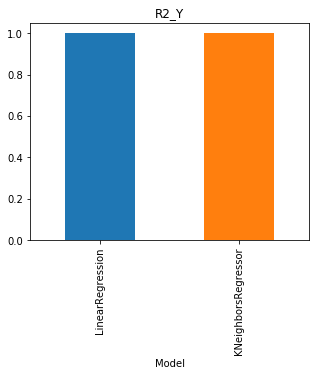

In [28]:
# Построим графики и посмотрим какая модель показала лучший результат
fig, axes = plt.subplots(ncols=1, figsize=(5,4))
TestModels.R2_Y.plot(ax=axes,kind='bar', title='R2_Y');

In [ ]:
# Обучим еще раз ту модель которая показала лучший результат
model = models[1]
model.fit(Xtrn, Ytrn)

In [ ]:
#Посмотрим веса всех признаков
model.feature_importances_

# Блок прогнозирования

In [84]:
# Т.к. Модель 2 показала лучший результат, берем ее

In [85]:
#Построим прогноз
#predictions = model1.predict(Xtest)

In [131]:
# Преобразуем в читаемый формат
predictions_new = list()
for i in range(len(predictions)):
    predictions_new.append(datetime.fromtimestamp(predictions4[i]))
predictions_new

[datetime.datetime(2018, 7, 31, 7, 4, 31, 800000),
 datetime.datetime(2018, 4, 7, 12, 44, 10, 700000),
 datetime.datetime(2018, 3, 30, 5, 4, 11, 160000),
 datetime.datetime(2018, 7, 16, 20, 35, 6, 380000),
 datetime.datetime(2018, 7, 23, 11, 14, 42, 700000),
 datetime.datetime(2018, 3, 5, 9, 18, 34, 302857),
 datetime.datetime(2018, 8, 8, 8, 46, 20, 760000),
 datetime.datetime(2018, 8, 7, 20, 24, 23, 550000),
 datetime.datetime(2018, 5, 19, 19, 8, 33, 800000),
 datetime.datetime(2018, 5, 12, 23, 8, 3, 960000),
 datetime.datetime(2018, 4, 9, 17, 16, 25, 440000),
 datetime.datetime(2018, 7, 22, 1, 28, 56, 760000),
 datetime.datetime(2018, 6, 28, 17, 24, 8, 520000),
 datetime.datetime(2018, 8, 31, 10, 2, 31, 346667),
 datetime.datetime(2018, 7, 22, 1, 12, 52, 800000),
 datetime.datetime(2018, 7, 28, 5, 9, 19, 440000),
 datetime.datetime(2018, 6, 7, 12, 53, 43, 920000),
 datetime.datetime(2018, 6, 4, 15, 12, 42, 560000),
 datetime.datetime(2018, 4, 20, 12, 23, 16, 780000),
 datetime.dateti